Here, we will perform some inferential statistics to examine trends and behaviors in our data before diving into the machine learning portion of our analysis.

First, we import some packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.random import seed
import seaborn as sns
seed(42)
sns.set()

We will define a few helper functions that perform frequently used tasks. These functions will return a CW/CCW portion of a dataframe and filter out data for a specific band.

In [2]:
def get_cw(df):
    """
    Returns the cw entries of a given dataframe.
    """
    return df[df['rotation'] == 'cw']

def get_ccw(df):
    """
    Returns the ccw entries of a given dataframe.
    """
    return df[df['rotation'] == 'ccw']

def get_band(df, band):
    """
    Returns data from a specific band of a given dataframe. Retains rotation column.
    """
    return pd.concat([df['rotation'], df.filter(regex='_%s' % band)], axis=1)

Next, we will load all of our data into dataframes and add them to a list to make it easier to iterate through them.

In [3]:
df_list = []
coordinates = pd.read_csv('data/coordinates.csv', index_col=0)
df_list.append(coordinates)
devaucouleurs = pd.read_csv('data/devaucouleurs.csv', index_col=0)
df_list.append(devaucouleurs)
exponential = pd.read_csv('data/exponential.csv', index_col=0)
df_list.append(exponential)
extinction = pd.read_csv('data/extinction.csv', index_col=0)
df_list.append(extinction)
fiber = pd.read_csv('data/fiber.csv', index_col=0)
df_list.append(fiber)
flags = pd.read_csv('data/flags.csv', index_col=0)
df_list.append(flags)
isophotal = pd.read_csv('data/isophotal.csv', index_col=0)
df_list.append(isophotal)
m = pd.read_csv('data/m.csv', index_col=0)
df_list.append(m)
model = pd.read_csv('data/model.csv', index_col=0)
df_list.append(model)
object_info = pd.read_csv('data/object_info.csv', index_col=0)
df_list.append(object_info)
petro = pd.read_csv('data/petro.csv', index_col=0)
df_list.append(petro)
position = pd.read_csv('data/position.csv', index_col=0)
df_list.append(position)
prof = pd.read_csv('data/prof.csv', index_col=0)
df_list.append(prof)
psf = pd.read_csv('data/psf.csv', index_col=0)
df_list.append(psf)
signal = pd.read_csv('data/signal.csv', index_col=0)
df_list.append(signal)
sky = pd.read_csv('data/sky.csv', index_col=0)
df_list.append(sky)
stokes = pd.read_csv('data/stokes.csv', index_col=0)
df_list.append(stokes)
target = pd.read_csv('data/target.csv', index_col=0)
df_list.append(target)
texture = pd.read_csv('data/texture.csv', index_col=0)
df_list.append(texture)
types = pd.read_csv('data/types.csv', index_col=0)
df_list.append(types)


Here, we will iterate over the columns of each dataframe and perform a two-tailed t-test for independent samples to test for a difference in means between CW and CCW samples. If the p-value is p < 0.05, we can reject the null hypothesis for that feature and add them to a list of significant features. If the p-value is p > 0.05, we fail to reject the null hypothesis and move on to the next column.

In [4]:
ALPHA = 0.05
significant_cols = []

for df in df_list:
    for col in df.columns[1:]:
        cw_variable = get_cw(df)[col].dropna()
        ccw_variable = get_ccw(df)[col].dropna()
        t_val, p_val = stats.ttest_ind(cw_variable, ccw_variable, equal_var=False)
        if p_val <= ALPHA:
            significant_cols.append(col)
            
#We will add in the "rotation" column to the significant_cols list since that is also a significant column.
significant_cols.append('rotation')

Then, we can combine all of our individual dataframes into one, and filter out any duplicate columns (the "rotation" column appears multiple times so we need to remove the duplicate occurrences).

After that, we can pull columns in the dataframe that were found to have a significant difference and separate them by band into five different dataframes.

In [5]:
data_df = pd.concat(df_list, axis=1)
data_df = data_df.loc[:,~data_df.columns.duplicated()]
sig_u = get_band(data_df.loc[:, data_df.columns.isin(significant_cols)], 'u').dropna()
sig_g = get_band(data_df.loc[:, data_df.columns.isin(significant_cols)], 'g').dropna()
sig_r = get_band(data_df.loc[:, data_df.columns.isin(significant_cols)], 'r').dropna()
sig_i = get_band(data_df.loc[:, data_df.columns.isin(significant_cols)], 'i').dropna()
sig_z = get_band(data_df.loc[:, data_df.columns.isin(significant_cols)], 'z').dropna()

sig_r.head()

,rotation,deVMag_r,lnLDeV_r,fracDeV_r,expMag_r,fiberMag_r,mE2_r,mRrCc_r,mCr4_r,petroMag_r,lnLStar_r,u_r,texture_r
0,cw,16.10062,-1144.432,0.424682,16.52792,18.38592,0.145458,59.92825,2.351259,16.43842,-17366.21,0.040750,53.89952
1,cw,15.54738,-2305.753,0.115188,16.06207,18.79992,-0.051602,234.89500,2.335506,16.10326,-22848.63,-0.004825,22.66961
2,cw,16.10127,-1618.459,1.000000,16.45433,18.05013,-0.074695,11.03953,2.433756,16.25098,-19031.26,-0.026030,113.40640
3,cw,13.89373,-28933.040,0.309477,13.47404,18.33965,0.294657,4543.60500,2.464617,13.34567,-114269.30,0.000595,630.19510
4,cw,14.99597,-3808.570,0.394344,15.42598,17.99603,0.327938,156.04720,2.449424,15.37511,-45717.66,0.018774,328.75400


We can plot histograms of various columns to see if we can visually observe the difference in CW and CCW distributions.

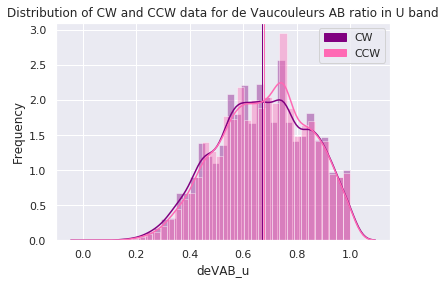

In [6]:
sns.distplot(get_cw(sig_u)['deVAB_u'], hist='true', color='purple')
plt.axvline(get_cw(sig_u)['deVAB_u'].mean(), color='purple', linewidth=1)
sns.distplot(get_ccw(sig_u)['deVAB_u'], hist='true', color='hotpink')
plt.axvline(get_ccw(sig_u)['deVAB_u'].mean(), color='hotpink', linewidth=1)

plt.ylabel('Frequency')
plt.title('Distribution of CW and CCW data for de Vaucouleurs AB ratio in U band')

cw_label = mpatches.Patch(color='purple', label='CW')
ccw_label = mpatches.Patch(color='hotpink', label='CCW')
plt.legend(handles=[cw_label, ccw_label])
plt.show()

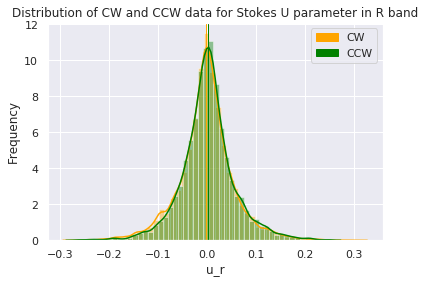

In [7]:
sns.distplot(get_cw(sig_r)['u_r'], hist='true', color='orange')
plt.axvline(get_cw(sig_r)['u_r'].mean(), color='orange', linewidth=1)
sns.distplot(get_ccw(sig_r)['u_r'], hist='true', color='green')
plt.axvline(get_ccw(sig_r)['u_r'].mean(), color='green', linewidth=1)

plt.ylabel('Frequency')
plt.title('Distribution of CW and CCW data for Stokes U parameter in R band')

cw_label = mpatches.Patch(color='orange', label='CW')
ccw_label = mpatches.Patch(color='green', label='CCW')
plt.legend(handles=[cw_label, ccw_label])
plt.show()

We see that the means of the CW and CCW distributions seem to be very close, but far enough apart that we were able to reject the null hypothesis.

Finally, we can investigate each band's significant columns by plotting their Seaborn pairplots. The pairplot for the I band has been included. 

We can take note of some interesting properties of certain features. For example, all of the columns that start with "frac" (fraction) have hard boundaries at 0 and 1 (which makes sense), and all of the columns that start with "ln" (natural log) have a hard boundary at zero (which also makes sense). These properties would have been difficult to determine if we had not visually inspected the data.

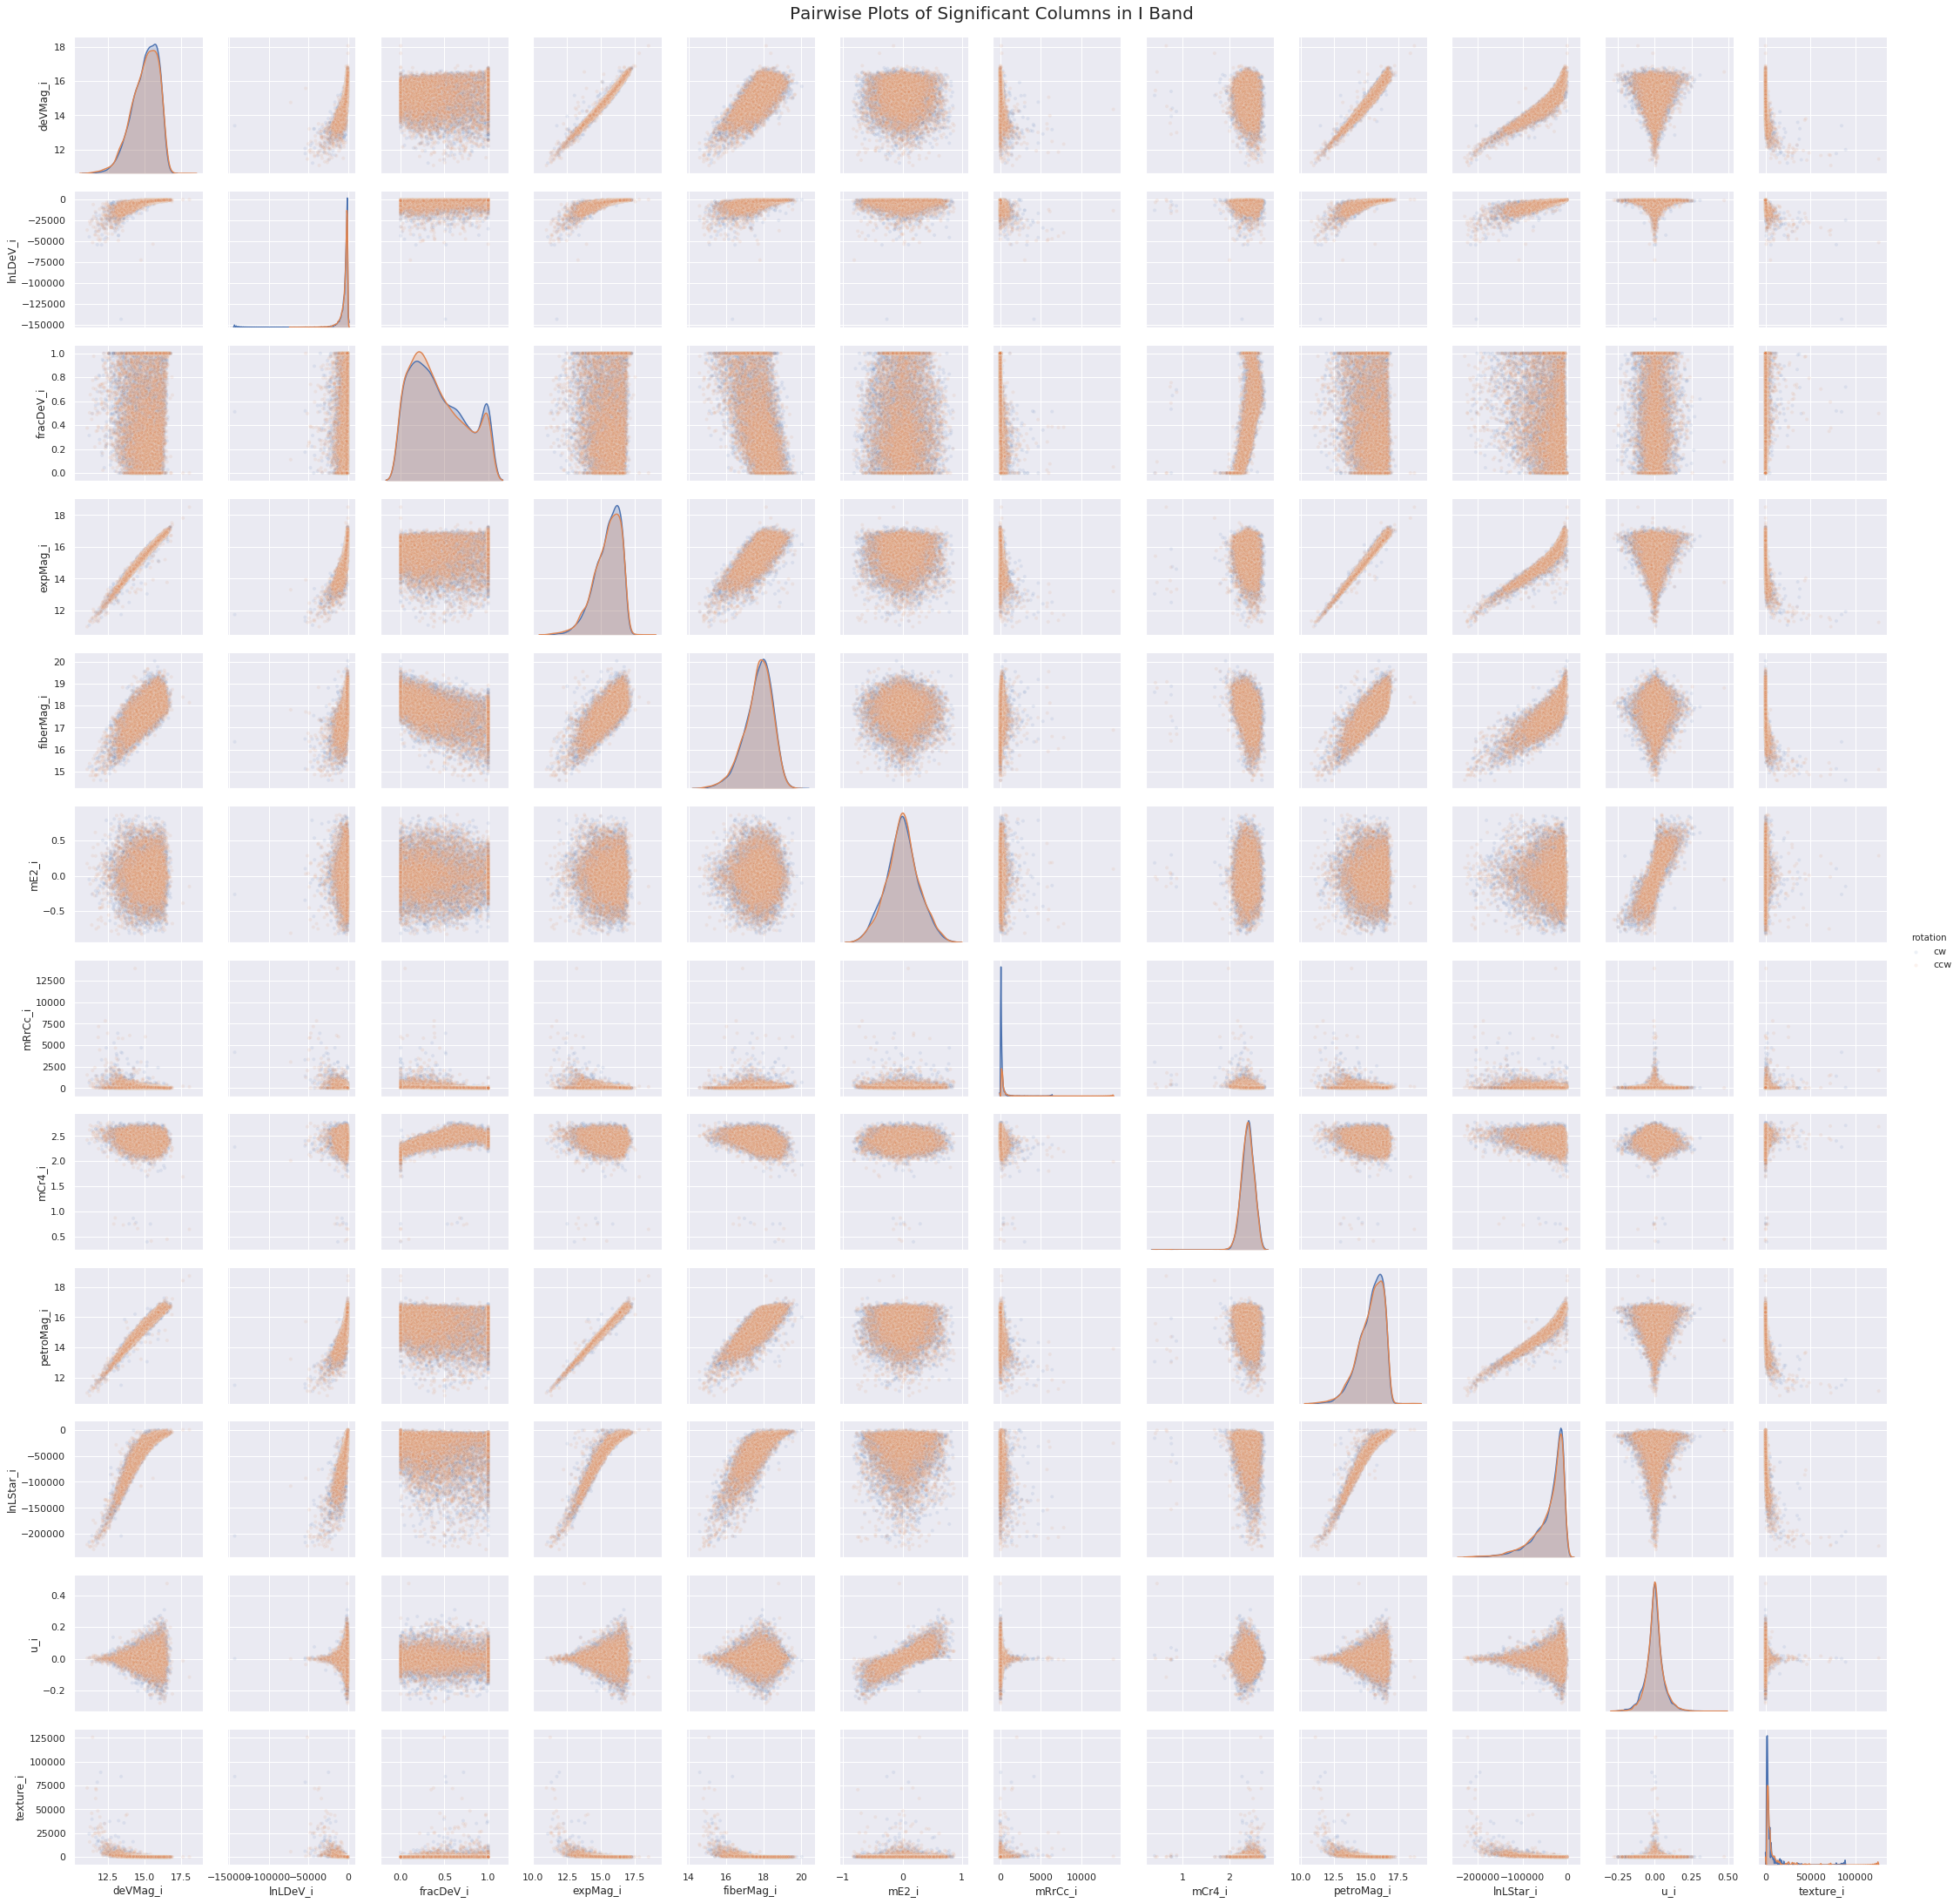

In [8]:
sns.pairplot(sig_i, hue='rotation', plot_kws={'alpha':0.1, 'size':0.25})
plt.suptitle('Pairwise Plots of Significant Columns in I Band', y=1.01, fontsize=20)
plt.show()